In [103]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import wandb 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [104]:
run = wandb.init(
    entity="hangoebl-j-johannes-kepler-universit-t-linz",
    project="image-rq-vae",
    config={
        "learning_rate": 0.001,
        "architecture": "RQ-VAE",
        "dataset": "MNIST",
        "epochs": 5000,
    },
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step,▁▁▁▁▂▁▁▁▁▂▂▃▃▄▅▄▆▆▆▇▃▃▄▄▅▆▆▇▇▇▂▂▂▃▃▄▅▅▆█
loss,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perplexity,▄▅▅▆▆▆▆▆▇█▇▇▇▆▆▇▇▄▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁▁▁▆▅▅▅▅
recon_error,█▄▂▃▁▁▁▁▁▁▅▃▂▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,4950
loss,0.0
perplexity,17.76886
recon_error,0.0


In [105]:
class Encoder(nn.Module):        
    def __init__(self, in_dim, h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),

        )

    def forward(self, x):
        return self.conv_stack(x)
    
class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 1, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)
    
class VectorQuantizer(nn.Module):
    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

In [106]:
class VQVAE(nn.Module):
    def __init__(self, h_dim,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(1, h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, min_encodings, min_encodings_idx = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, x_hat, perplexity, z_q, min_encodings, min_encodings_idx

In [ ]:
h_dim = 128
n_embeddings = 512
embedding_dim = 64
beta = 0.25
save_img_embedding_map = False

learning_rate = 0.001
epochs = 5000
log_interval = 50
transform = transforms.Compose([
    transforms.ToTensor(),
])

model = VQVAE(h_dim,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

model.train()

results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
x_train_var = np.var(train_dataset.data.numpy())
print(x_train_var)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

def train():
    pbar = tqdm(range(epochs),total=epochs, desc="Training VQVAE", unit="epoch")
    for i in pbar:
        (x, _) = next(iter(train_loader))
        x = x.to(device)
        optimizer.zero_grad()

        embedding_loss, x_hat, perplexity, _, _, _ = model(x)
        recon_loss = torch.mean((x_hat - x)**2) / x_train_var
        loss = recon_loss + embedding_loss

        loss.backward()
        optimizer.step()

        results["recon_errors"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        if i % log_interval == 0:
            recon_error = np.mean(results["recon_errors"][-log_interval:])
            loss = np.mean(results["loss_vals"][-log_interval:])
            perplexity = np.mean(results["perplexities"][-log_interval:])
            

            wandb.log({
                'Step': i,
                'recon_error': recon_error,
                'loss': loss,
                'perplexity': perplexity,
            })
        pbar.set_postfix({
            "Recon_Error":f"{recon_error}",
            "Loss":f"{loss}",
            "Perplexity":f"{perplexity}"}
        )
    pbar.close()

train()

6172.850482291342


Training VQVAE:  82%|████████▏ | 4076/5000 [04:14<00:58, 15.88epoch/s, Recon_Error=2.0649849830078892e-06, Loss=2.1810301404912025e-06, Perplexity=18.39760971069336] 

torch.Size([49, 1])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

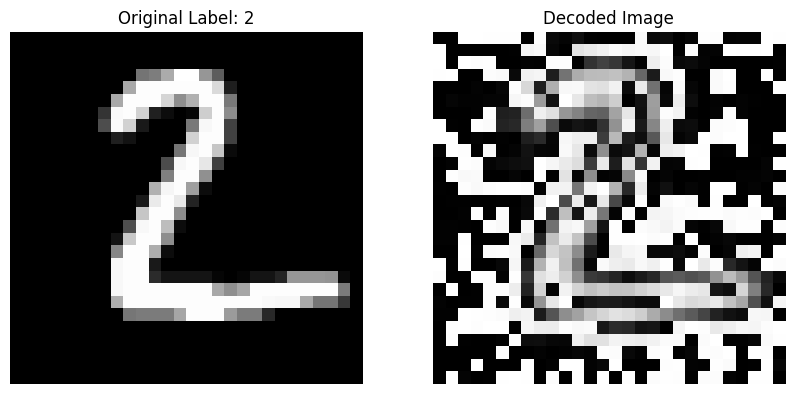

In [ ]:
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Step 3: Select a random image from the test set
random_idx = 1
image, label = test_dataset[random_idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Step 4: Pass the image through your model (encoder + quantizer + decoder)
with torch.no_grad():  # Disable gradient computation for inference
    embedding_loss, x_hat, perplexity, z_q, min_encodings, min_encodings_idx = model(image)
    print(min_encodings_idx.shape)

from torchvision.transforms import ToPILImage
# Step 5: Convert the original and reconstructed images to PIL format for display
to_pil_image = ToPILImage()

# Original image
original_image = image.squeeze(0).cpu()  # Remove batch dimension and move to CPU
original_image_pil = to_pil_image(original_image)

# Decoded (reconstructed) image
decoded_image = x_hat.squeeze(0).cpu()  # Remove batch dimension and move to CPU
decoded_image_pil = to_pil_image(decoded_image)

# Step 6: Display the original and decoded images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image_pil, cmap='gray')
axes[0].set_title(f"Original Label: {label}")
axes[0].axis('off')

axes[1].imshow(decoded_image_pil, cmap='gray')
axes[1].set_title("Decoded Image")
axes[1].axis('off')